In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import traceback
import matplotlib.pyplot as plt

from core.datasets import *
from core.networks import *
from core.models import *

# Parameters

In [3]:
device = torch.device('cuda:0')
lr = 1e-3
n_epochs = 34
early_stop_threshold = 1e-2

batch_size = 32
n_workers = 4
shuffle = True

cae_latent_dim = 32
cae_stride = 2
resnet_model_no = 34

dir_data = '/Users/Linsu Han/Documents/Data/celeba/clean/'
dir_load = None
dir_save = '../resources/models/'
path_metadata = '/Users/Linsu Han/Documents/Data/celeba/list_attr_celeba.csv'
features = ['Attractive', 'Bags_Under_Eyes', 'Bangs', 'Chubby', 'Eyeglasses', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Smiling', 'Wearing_Lipstick', 'Young']

# Initialize Dataloader

In [4]:
dataset = CelebA(dir_data, path_metadata, features)

Processing Labels...


100%|████████████████████████████████████████████████████████████████████████| 202599/202599 [00:47<00:00, 4235.36it/s]


In [5]:
train_len = int(len(dataset)*.8)
val_len = len(dataset) - train_len
print(train_len, val_len)

118228 29557


In [6]:
dataset_train = torch.utils.data.Subset(dataset, list(range(0, train_len)))
dataset_val = torch.utils.data.Subset(dataset, list(range(train_len, len(dataset))))

In [7]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle, num_workers=n_workers)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle, num_workers=n_workers)

# Initialize Networks

In [8]:
x_shape = (3, 224, 224)
network_cae = ConvAutoencoder(cae_latent_dim, *x_shape, stride=cae_stride).to(device)
network_resnet = ResNet(34, len(features), in_channels=3).to(device)

# Initialize Models

In [9]:
model_cae = ModelCAE(network_cae, lr=lr)
model_cls = ModelSigmoidClassifier(network_resnet, lr=lr)

# Loading Saved Models

In [10]:
if dir_load is not None:
    model_cae.load(dir_load + 'cae.pth')
    model_cls.load(dir_load + 'cls.pth')

# Training Loop

In [11]:
model_cae.network.train()
model_cls.network.train()

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [12]:
torch.cuda.empty_cache()
df_cae = []
df_cls = []

loss_cae_val = np.inf
loss_cls_val = np.inf

for epoch in range(n_epochs):
    print(f'Epoch: {epoch}')
    
    for idx, x, y in tqdm(dataloader_train):
        try:
            x = x.to(device)
            y = y.to(device)
            model_cae.update(x)
            model_cls.update(x, y)
        except Exception as e:
            traceback.print_exc()
            breakpoint()
    
    loss_cae_train = np.mean(model_cae.loss_history['training'][-len(dataloader_train):])
    loss_cls_train = np.mean(model_cls.loss_history['training'][-len(dataloader_train):])
    print('Training Loss (cae):', loss_cae_train)
    print('Training Loss (cls):', loss_cls_train)
    
    for idx, x, y in tqdm(dataloader_val):
        try:
            x = x.to(device)
            y = y.to(device)
            out_cae = model_cae.eval(x)
            out_cls = model_cls.eval(x, y)
        except Exception as e:
            traceback.print_exc()
            breakpoint()
    
    loss_cae_val_prev = loss_cae_val
    loss_cls_val_prev = loss_cls_val
    
    loss_cae_val = np.mean(model_cae.loss_history['validation'][-len(dataloader_val):])
    loss_cls_val = np.mean(model_cls.loss_history['validation'][-len(dataloader_val):])
    print('Validation Loss (cae):', loss_cae_val)
    print('Validation Loss (cls):', loss_cls_val)

    info_cae  = {'Epoch':epoch, 'Model':'cae', 'Training Loss':loss_cae_train, 'Validation Loss':loss_cae_val}
    info_cls  = {'Epoch':epoch, 'Model':'cls', 'Training Loss':loss_cls_train, 'Validation Loss':loss_cls_val}
    
    df_cae.append(info_cae)
    df_cls.append(info_cls)

    print('-'*13)
    
    early_stop = loss_cls_val/loss_cls_val_prev > 1 + early_stop_threshold
    if early_stop:
        break

Epoch: 0


  0%|                                                                                         | 0/3695 [00:00<?, ?it/s]c:\program files\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████| 3695/3695 [07:37<00:00,  8.07it/s]


Training Loss (cae): 0.015147383530348217
Training Loss (cls): 0.2173452177393743


100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [00:43<00:00, 21.14it/s]


Validation Loss (cae): 0.009211955254381418
Validation Loss (cls): 0.18952897506326566
-------------
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3695/3695 [07:51<00:00,  7.83it/s]


Training Loss (cae): 0.008761375600091497
Training Loss (cls): 0.17745048178306935


100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [00:43<00:00, 21.21it/s]


Validation Loss (cae): 0.008494678822757265
Validation Loss (cls): 0.17435491424521585
-------------
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████| 3695/3695 [07:36<00:00,  8.09it/s]


Training Loss (cae): 0.008396872175234863
Training Loss (cls): 0.16546946210491803


100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [00:43<00:00, 21.08it/s]


Validation Loss (cae): 0.008279628749307873
Validation Loss (cls): 0.1701318503103473
-------------
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████| 3695/3695 [07:36<00:00,  8.10it/s]


Training Loss (cae): 0.008214545997769569
Training Loss (cls): 0.15693691237772914


100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [00:43<00:00, 21.25it/s]


Validation Loss (cae): 0.008108906871719826
Validation Loss (cls): 0.16505715398529133
-------------
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████| 3695/3695 [08:00<00:00,  7.68it/s]


Training Loss (cae): 0.008095823101200295
Training Loss (cls): 0.1492964142673877


100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [00:44<00:00, 20.57it/s]


Validation Loss (cae): 0.008043945456040596
Validation Loss (cls): 0.16414440316006992
-------------
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████| 3695/3695 [07:34<00:00,  8.13it/s]


Training Loss (cae): 0.00800320957226525
Training Loss (cls): 0.14152539461972102


100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [00:44<00:00, 20.77it/s]

Validation Loss (cae): 0.007981754250792198
Validation Loss (cls): 0.16724167498094694
-------------


In [13]:
df_cae = pd.DataFrame(df_cae)

In [14]:
df_cls = pd.DataFrame(df_cls)

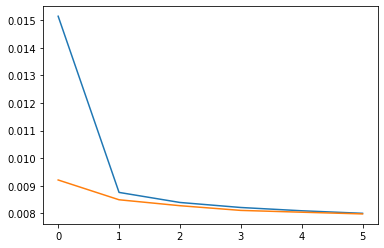

In [15]:
plt.plot(df_cae['Training Loss'])
plt.plot(df_cae['Validation Loss'])

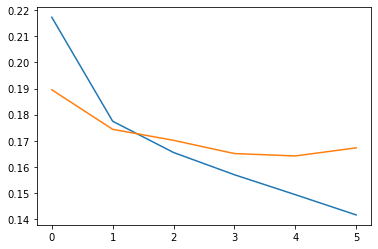

In [16]:
plt.plot(df_cls['Training Loss'])
plt.plot(df_cls['Validation Loss'])

# Saving Models

In [17]:
if not os.path.exists(dir_save):
    os.makedirs(dir_save)
model_cae.save(dir_save + 'cae.pth')
model_cls.save(dir_save + 'cls.pth')